In [37]:
import os
import glob
import numpy as np
import itertools
import random
import multiprocessing
from multiprocessing.dummy import Pool
import pandas as pd
import datetime

from skimage import feature
from PIL import Image, ImageOps
import pywt
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy.stats import mode

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn import neighbors, linear_model

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import moment, kurtosis, skew
from scipy.signal import wiener

from skimage.restoration import denoise_wavelet
%matplotlib inline

In [3]:
path2train = 'data/train/'
path2test = 'data/test'

In [4]:
img_width = img_height=512

In [5]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 7


In [6]:
def preProcessing(img, row=0, col=0, center=True, isTrain = True):
    
    '''img = resizeImage(img) # cant resize the image!!
    img = RGB2Gray(img) #cant transform to rgb!'''
    
    if isTrain:
        if center:
            img = crop_image_center(img, img_height=img_height, img_width=img_width)
        else:
            img = crop_image_corners(img, row=row, col=col, img_height=img_height, img_width=img_width)

    noise = np.array(img).astype(float) - filter_median(img).astype(float)
    noise=np.abs(noise)
    #noise = localBinaryPatterns(noise)
    #noise = img - filter_wavelet(img)
    noise = noise_wavelet(noise)
    #noise = vectorizeImage(img, nb_channels=3)
    return noise

In [7]:
def crop_image_corners(img, row, col, img_width=128, img_height=128):

    width, height = img.size   # Get dimensions

    x = row*(width-img_width)
    y = col*(height-img_height)
    crop = img.crop((x, y, x + img_width, y + img_height))
    
    return crop

In [8]:
def crop_image_center(img, img_width=128, img_height=128):
    width, height = img.size   # Get dimensions

    left = (width - img_width)/2
    top = (height - img_height)/2
    right = (width + img_width)/2
    bottom = (height + img_height)/2

    crop = img.crop((left, top, right, bottom))
    return crop

In [9]:
def RandomCropImage(img, img_width=128, img_height=128):
    
    width, height = img.size   # Get dimensions

    idx_width = random.randint(0, width - img_width)
    idx_height = random.randint(0, height - img_height)

    return img.crop((idx_width, idx_height, idx_width+img_width, idx_height + img_height))

In [10]:
def vectorizeImage(img, img_width=128, img_height=128, nb_channels = 1):
    return img.reshape(-1,img_width * img_height * nb_channels)

In [11]:
def filter_median(img, factor=2):
    return ndimage.median_filter(img, factor)

In [12]:
def filter_gaussian(img):
    return ndimage.gaussian_filter(img, sigma=3)

In [13]:
def filter_wavelet(img):
    return denoise_wavelet(img=img, multichannel=True)

In [14]:
def resizeImage(img, img_width=128, img_height=128):
    img = img.resize((img_width, img_height))
    return np.array(img)

In [15]:
def localBinaryPatterns(img, numPoints=24, radius=2):
    
    img_lbp = np.zeros(np.array(img).shape)
    for i in range(np.array(img).shape[2]):
        img_lbp[:,:,i] = feature.local_binary_pattern(img[:,:,i], numPoints,
                    radius, method="uniform")
    return img_lbp

In [16]:
def noise_wavelet(img, n_moments=9):
    
    res = []
    for i in range(0, img.shape[2]):
        coeffs = pywt.dwt2(img[:,:,i], wavelet='haar')
        cA, (cH, cV, cD) = coeffs

        for j in range(1, n_moments):
            res.append(moment(cH.ravel(), moment=j))
            res.append(moment(cV.ravel(), moment=j))
            res.append(moment(cD.ravel(), moment=j))

        
        res.append(kurtosis(cH.ravel()))
        res.append(kurtosis(cV.ravel()))
        res.append(kurtosis(cD.ravel()))
        res.append(skew(cH.ravel()))
        res.append(skew(cV.ravel()))
        res.append(skew(cD.ravel()))
    return res

In [17]:
def RGB2Gray(img):
    img = np.array(img)
    return np.dot(img[...,:3], [0.299, 0.587, 0.114]).astype(int)

In [18]:
def extractImage(path, row=0, col=0, center=True, isTrain = True):

    with Image.open(path) as img:
        img = preProcessing(img, row, col, center, isTrain)
    if isTrain:
        target = path.split('/')[-2]
    else:
        target = path.split('/')[-1]
    
    return img, target

In [19]:
def extractImage_helper(args):
    return extractImage(*args)

In [20]:
def extractImagesParallel(path_lst, row=0, col=0, center=True, isTrain=True, threads=2):
    pool = Pool(threads)
    #imgs, targets = zip(*pool.map(extractImage, path))
    #result = pool.map(extractImage, path_lst)
    job_args = [(path, row, col, center, isTrain) for path in path_lst] 
    result = pool.map(extractImage_helper, job_args)
    pool.close()
    pool.join()
    return result

In [21]:
def get_data(path, row=0, col=0, center=True, nb_threads=2, format_file = '*.jpg', isTrain = True):
    results = []

    for subdir, dirs, files in os.walk(path):
        if subdir.split('/')[-1] != '':

            print('Reading files from dir: {}'.format(subdir))

            path_folder = os.path.join(subdir, format_file)
            filesPath = glob.glob(path_folder) 

            res  = extractImagesParallel(filesPath, row, col, center, isTrain, threads=nb_threads)
            results.append(res)
    
    flattened_list = [y for x in results for y in x]
    X, y = map(list, zip(*flattened_list))

    X = np.array(X)
    y = np.array(y)
    
    if np.array(X).shape[1] == 1:
        X = np.squeeze(X, axis=1)
    
    return X, y

In [22]:
crop_borders = False

In [23]:
print('Crop borders: {}'.format(crop_borders))

if crop_borders:

    params = {'center': {
                'row': 0, 'col': 0, 'center': True
                },
              'rb': {
                'row': 1, 'col': 0, 'center': False
                },
              'lb': {
                'row': 0, 'col': 0, 'center': False
                },
              'rh': {
                'row': 0, 'col': 1, 'center': False
                },
              'lh': {
                'row': 1, 'col': 1, 'center': False
                }
             }
else:
    
    params = {'center': {
                'row': 0, 'col': 0, 'center': True
                }
             }

Crop borders: False


In [24]:
X_dict = {}
y_dict = {}

for k, v in params.items():
    params_lst = []
    for k1, v1 in v.items():
        params_lst.append(v1)
    
    print('\nReading training data for {} image...\n'.format(k))
    X_dict[k], y_dict[k] = get_data(path2train, row=params_lst[0], col=params_lst[1],
                                        center=params_lst[2], nb_threads=cpu_count)


Reading training data for center image...

Reading files from dir: data/train/iPhone-4s
Reading files from dir: data/train/Motorola-Droid-Maxx
Reading files from dir: data/train/HTC-1-M7
Reading files from dir: data/train/Samsung-Galaxy-S4
Reading files from dir: data/train/Motorola-X
Reading files from dir: data/train/Motorola-Nexus-6
Reading files from dir: data/train/LG-Nexus-5x
Reading files from dir: data/train/Samsung-Galaxy-Note3
Reading files from dir: data/train/iPhone-6
Reading files from dir: data/train/Sony-NEX-7


In [25]:
print('\nReading testing data...\n')
X_test, fname_test = get_data(path2test,  row=params_lst[0], col=params_lst[1],
                            center=params_lst[2], nb_threads=cpu_count, format_file='*.tif', isTrain=False)


Reading testing data...

Reading files from dir: data/test


In [26]:
#https://www.youtube.com/watch?v=gAKQOZ5zIWg&index=49&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN

### Normalization

In [27]:
normalization_type = 'zScore'

In [28]:
print('Normalization type: {}'.format(normalization_type))

if normalization_type == 'minMax':
    scaler = MinMaxScaler()
    
elif normalization_type == 'zScore':        
    scaler =  StandardScaler()

Normalization type: zScore


In [29]:
vectorize_crop_features = False

In [30]:
print('Vectorize crop features {}'.format(vectorize_crop_features))

if vectorize_crop_features:

    #Combine each feature image crop
    X_combined = np.empty(shape=[len(X_dict['center']), X_dict['center'].shape[1]*len(params.keys())])

    idx = 0
    for k in params.keys():
        start = idx*X_test_dict['center'].shape[1]
        X_combined[:, start:start + X_test_dict['center'].shape[1]] = X_dict[k]
        idx+=1
    y_combined = y_dict['center']    
    X_train, X_valid, y_train, y_valid = train_test_split(X_combined, y_combined, test_size=test_size, random_state=42)

else:

    # Calculate for each image patch
    X_train_dict = {}
    X_valid_dict = {}
    y_train_dict = {}
    y_valid_dict = {}
    X_test_dict = {}

    
    test_size = 0.2

    for k in params.keys():
        X_train_dict[k], X_valid_dict[k], y_train_dict[k], y_valid_dict[k] = train_test_split(X_dict[k], y_dict[k], test_size=test_size, random_state=42)

        ## data normalization
        X_train_dict[k] = scaler.fit_transform(X_train_dict[k])
        X_valid_dict[k] = scaler.transform(X_valid_dict[k])
        X_test_dict[k] = scaler.transform(X_test)    
        
    print('Shape of the training data X: {}, y: {}'.format(X_train_dict['center'].shape, y_train_dict['center'].shape))
    print('Shape of the valid data X: {}, y: {}'.format(X_valid_dict['center'].shape, y_valid_dict['center'].shape))

Vectorize crop features False
Shape of the training data X: (2200, 90), y: (2200,)
Shape of the valid data X: (550, 90), y: (550,)


# Model

### Logistic Regression

In [31]:
if vectorize_crop_features:


    lr_model = linear_model.LogisticRegression(max_iter=20)
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_valid)

    print('Training model for key: {}...'.format(k))
    print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(lr_model.score(X_train, y_train)))
    print('Accuracy of logistic regression classifier on valid set: {:.2f}\n'.format(lr_model.score(X_valid, y_valid)))
        
        
else:

    lr_model = {}
    y_pred_lr = {}

    for k in params.keys():
        lr_model[k] = linear_model.LogisticRegression(max_iter=100)
        lr_model[k].fit(X_train_dict[k], y_train_dict[k])
        y_pred_lr[k] = lr_model[k].predict(X_valid_dict[k])

        print('Training model for key: {}...'.format(k))
        print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(lr_model[k].score(X_train_dict[k], y_train_dict[k])))
        print('Accuracy of logistic regression classifier on valid set: {:.2f}\n'.format(lr_model[k].score(X_valid_dict[k], y_valid_dict[k])))

Training model for key: center...
Accuracy of logistic regression classifier on train set: 0.52
Accuracy of logistic regression classifier on valid set: 0.47



In [32]:
# MUITO BOM!
#http://sdsawtelle.github.io/blog/output/week4-andrew-ng-machine-learning-with-python.html
#http://neuralnetworksanddeeplearning.com/chap3.html#introducing_the_cross-entropy_cost_function

### Neural Network

In [33]:
if vectorize_crop_features:


    mlp_model = MLPClassifier(hidden_layer_sizes=(256,), max_iter=100, alpha=1e-4,
                        solver='sgd', verbose=0, tol=1e-4, random_state=1,
                        learning_rate_init=.1, early_stopping=False)

    mlp_model.fit(X_train, y_train)
    y_pred_mlp = mlp_model.predict(X_valid)

    print('Training model for key: {}...'.format(k))
    print('Accuracy of Neural Network classifier on train set: {:.2f}'.format(mlp_model.score(X_train, y_train)))
    print('Accuracy of Neural Network classifier on valid set: {:.2f}\n'.format(mlp_model.score(X_valid, y_valid)))
        
        
else:

    mlp_model = {}
    y_pred_mlp = {}

    for k in params.keys():
        mlp_model[k] = MLPClassifier(hidden_layer_sizes=(512,), max_iter=100, alpha=1e-4,
                        solver='sgd', verbose=0, tol=1e-4, random_state=1,
                        learning_rate_init=.1, early_stopping=False)

        mlp_model[k].fit(X_train_dict[k], y_train_dict[k])
        y_pred_mlp[k] = mlp_model[k].predict(X_valid_dict[k])

        print('Training model for key: {}...'.format(k))
        print('Accuracy of Neural Network classifier on train set: {:.2f}'.format(mlp_model[k].score(X_train_dict[k], y_train_dict[k])))
        print('Accuracy of Neural Network classifier on valid set: {:.2f}\n'.format(mlp_model[k].score(X_valid_dict[k], y_valid_dict[k])))

Training model for key: center...
Accuracy of Neural Network classifier on train set: 0.85
Accuracy of Neural Network classifier on valid set: 0.54



## K-means

In [42]:
if vectorize_crop_features:

    k_means_model = neighbors.KNeighborsClassifier(n_neighbors=10)    
    k_means_model.fit(X_train, y_train)
    y_pred_kmeans = k_means_model.predict(X_valid)

    print('Training model for key: {}...'.format(k))
    print('Accuracy of K-means classifier on train set: {:.2f}'.format(k_means_model.score(X_train, y_train)))
    print('Accuracy of K-means classifier on valid set: {:.2f}\n'.format(k_means_model.score(X_valid, y_valid)))
        
        
else:

    k_means_model = {}
    y_pred_k_means = {}

    for k in params.keys():
        k_means_model[k] = neighbors.KNeighborsClassifier(n_neighbors=10)
        k_means_model[k].fit(X_train_dict[k], y_train_dict[k])
        y_pred_k_means[k] = k_means_model[k].predict(X_valid_dict[k])

        print('Training model for key: {}...'.format(k))
        print('Accuracy of K-means classifier on train set: {:.2f}'.format(k_means_model[k].score(X_train_dict[k], y_train_dict[k])))
        print('Accuracy of K-means classifier on valid set: {:.2f}\n'.format(k_means_model[k].score(X_valid_dict[k], y_valid_dict[k])))

Training model for key: center...
Accuracy of K-means classifier on train set: 0.53
Accuracy of K-means classifier on valid set: 0.46



### Create en ensemble

In [45]:
camara_models = ['HTC-1-M7', 'LG-Nexus-5x', 'Motorola-X', 'Sony-NEX-7',
'iPhone-4s', 'Motorola-Droid-Maxx', 'Samsung-Galaxy-Note3',
'iPhone-6', 'Motorola-Nexus-6', 'Samsung-Galaxy-S4' ]

lb_make = LabelEncoder()
le = lb_make.fit(camara_models)

In [47]:
all_y_test = np.empty(shape=[len(X_test_dict[k]), 3])
all_y_valid = np.empty(shape=[len(X_valid_dict[k]), 3])

all_y_test[:, 0] = le.transform(k_means_model[k].predict(X_test_dict[k]))
all_y_test[:, 1] = le.transform(k_means_model[k].predict(X_test_dict[k]))
all_y_test[:, 2] = le.transform(k_means_model[k].predict(X_test_dict[k]))

all_y_valid[:, 0] = le.transform(k_means_model[k].predict(X_valid_dict[k]))
all_y_valid[:, 1] = le.transform(k_means_model[k].predict(X_valid_dict[k]))
all_y_valid[:, 2] = le.transform(k_means_model[k].predict(X_valid_dict[k]))

In [48]:
out_valid, _ = mode(all_y_valid, axis=-1)
predict_valid_ensemble = out_valid.ravel()
predict_valid_ensemble = le.inverse_transform(predict_valid_ensemble.astype(int))

out_test, _ = mode(all_y_test, axis=-1)
predict_test_ensemble = out_test.ravel()
predict_test_ensemble = le.inverse_transform(predict_test_ensemble.astype(int))

/home/renatolr/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/renatolr/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [51]:
100*(np.sum(predict_valid_ensemble==y_valid_dict[k])/len(predict_valid_ensemble))

46.18181818181818

## Evaluate results

In [99]:
print('Analaysing for image crop: {}'.format(k))

cm_lr = confusion_matrix(y_valid_dict[k], y_pred_lr[k])
cm_mlp = confusion_matrix(y_valid_dict[k], y_pred_mlp[k])
#http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html

Analaysing for image crop: center


In [100]:
def plot_cm(cm, title='Confusion matrix', cmap=None, normalize=True):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.title(title)
    plt.suptitle('Confusion matrix for image crop: {}'.format(k))

Normalized confusion matrix
Normalized confusion matrix


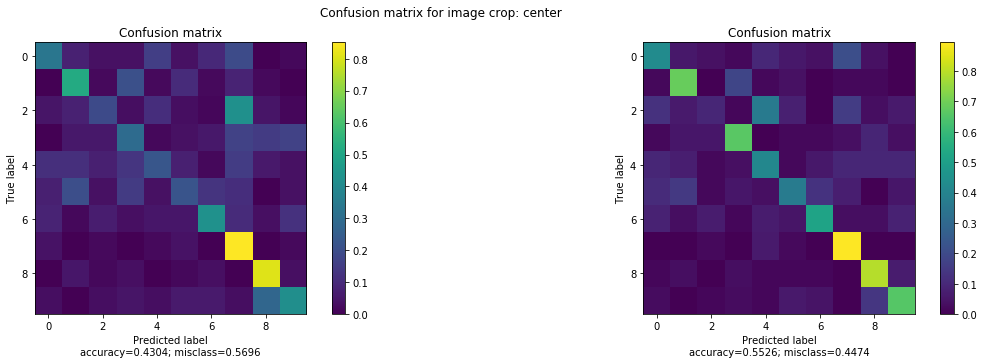

In [101]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plot_cm(cm_lr)

plt.subplot(1,2,2)
plot_cm(cm_mlp)

## Machine Ensemble (Majority Rule)

In [103]:
all_y_test_pred_mlp = np.empty(shape=[len(X_test_dict[k]), len(params.keys())])
all_y_test_pred_lr = np.empty(shape=[len(X_test_dict[k]), len(params.keys())])

idx = 0
for k in params.keys():
    all_y_test_pred_mlp[:, idx] = le.transform(mlp_model[k].predict(X_test_dict[k]))
    all_y_test_pred_lr[:, idx] = le.transform(lr_model[k].predict(X_test_dict[k]))

    idx+=1

In [104]:
out, _ = mode(all_y_test_pred_mlp, axis=-1)
predict_ensemble = out.ravel()

In [105]:
predict_ensemble = le.inverse_transform(predict_ensemble.astype(int))

/home/renatolr/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [106]:
def generate_submission_file(fname, predictions, info='camara_model'):
    
    now = datetime.datetime.now()
    
    submission_df = pd.DataFrame()
    submission_df['fname'] = fname
    submission_df['camera'] = [x for x in predictions]
    
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    submission_df.to_csv(sub_file, index=False)
    print('done!')

In [107]:
generate_submission_file(fname_test, predict_ensemble)

done!


In [42]:
def showCamaraTransformations():

    plt.figure(figsize=(20,5))
    path = 'data/train/iPhone-4s/(iP4s)9.jpg'
    with Image.open(path) as img:
        plt.subplot(1,3,1)
        img = RGB2Gray(img)
        img_wav = denoise_wavelet(img)
        plt.imshow(np.round(img-img_wav), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1,3,2)
        img_mean = median_filter(img, factor=4)
        plt.imshow(np.round(img-img_mean), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1,3,3)
        img_lbp = localBinaryPatterns(img)
        plt.imshow(img_lbp, cmap='gray')
        plt.axis('off')
        
#showCamaraTransformations()

In [57]:
path = 'data/train/iPhone-4s/(iP4s)9.jpg'
img = Image.open(path)
noise = np.array(img).astype(float) - filter_median(img).astype(float)
noise=np.abs(noise)
lbp = localBinaryPatterns(noise)
#noise = noise.astype(int)

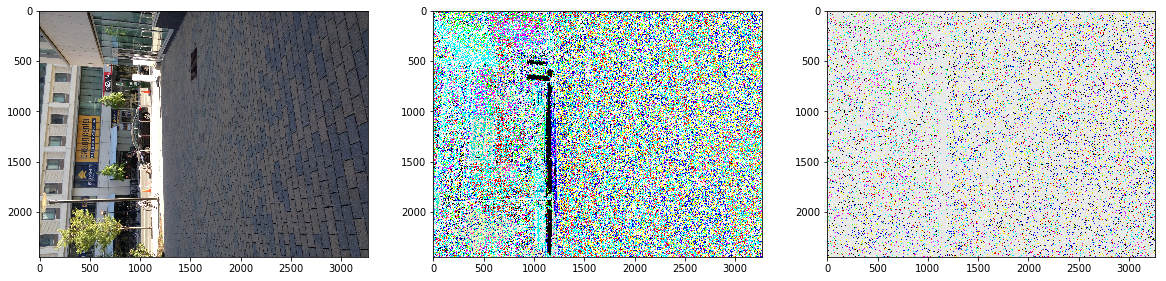

In [59]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(noise)
plt.subplot(1,3,3)
plt.imshow(lbp)

In [ ]:
'''path = 'data/train/iPhone-4s/(iP4s)9.jpg'
img = Image.open(path)
plt.imshow(crop_image_corners(img, row=1, col=0))'''

In [ ]:
print(np.array(X).shape)
img_wav_filtered = denoise_wavelet(X, multichannel=True, convert2ycbcr=True,  mode='soft')

### Wavelet

In [ ]:
'''
import glob, os
folder = 'data/train/Sony-NEX-7'
for filename in glob.iglob(os.path.join(folder, '*.JPG')):
    os.rename(filename, filename[:-4] + '.jpg')
'''

In [ ]:
def showCamaraPhotos(X, y=[], is_train =True, img_width=128, img_height=128, nb_channels = 1):

    idx = random.randint(0,len(X))
    if is_train:
        plt.title(y[idx])
    img = X[idx].reshape(img_width, img_height, nb_channels)
    if nb_channels == 1:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')
    
plt.figure(figsize=(20,5))
for i in range(0, 3):
    plt.subplot(1,3,i+1)
    showCamaraPhotos(X, y, nb_channels=3)